## Optimizing a constant window parameter throughout

In [28]:
import torch
import matplotlib.pyplot as plt
import math
import IPython.display as ipd
from jupyterthemes import jtplot
jtplot.style()
%config InlineBackend.figure_format = 'retina'

In [29]:
s = torch.sin(torch.cumsum(2 * math.pi * torch.linspace(16, 2000, 4096) / 4096, 0))
s *= torch.hann_window(len(s)) ** .5

In [30]:
ipd.Audio(s.numpy(), rate=4096)

In [34]:
from tqdm import trange

def dithering_int(n):
    if n == int(n):
        return int(n)
    return int(torch.bernoulli((n - int(n))) + int(n))

class NumericalError(Exception):
    def __init__(self, message, grad_hist=None, window_times_signal_grads=None, f_grad=None):
        self.message = message
        self.grad_hist = grad_hist
        self.window_times_signal_grads = window_times_signal_grads
        self.f_grad = f_grad

    def __str__(self):
        if self.message:
            return 'NumericalError, {0} '.format(self.message)
        else:
            return 'NumericalError'

def optimize_entire_window_length(s, initial_sigma_over_sr=12.0/4096, lr=1e-1, sr=4096):
    import torch
    sigma = torch.tensor(initial_sigma_over_sr * sr, requires_grad=True)
    sigma_grad_hist = []
    import torch.optim

    optimizer = torch.optim.AdamW([sigma], lr=lr, amsgrad=True, weight_decay=0)
    #optimizer = torch.optim.RMSprop([sigma], lr=lr)

    sigma_hist = []
    kur_hist = []
    plt.figure(figsize=(22, 15))

    for ep in trange(901):
        optimizer.zero_grad()
        
        sz = sigma * 6
        sz = torch.clamp(sz, min=1, max=len(s) - 1)
        # smallest sz be 2
        hp = sz / 2
        
        if torch.isnan(sz):
            raise NumericalError(
                f'size became NaN at iteration {ep}, sigma: {sigma}')

        intsz = dithering_int(sz)
        inthp = dithering_int(hp)

        m = torch.arange(0, intsz, dtype=torch.float32)
        window = torch.exp(-0.5 * torch.pow((m - sz / 2) / (sigma + 1e-7), 2))
        # window_norm = window / torch.sum(window)
        window_norm = window
        
        if torch.isnan(window_norm).any():
            raise NumericalError(
                f'window become NaN at iteration {ep}, sigma: {sigma}')
        
        window_times_signal = [window_norm * s[i:i+intsz] for i in range(0, len(s) - intsz, inthp)]
        f = torch.stack([torch.rfft(x, signal_ndim=1, normalized=True) for x in window_times_signal], dim=1)
        # pytorch would produce nan if this is
        # a = (f[..., 0] ** 2 + f[..., 1] ** 2).sqrt(),
        # and pow(a, 4), pow(a, 2), ... below
        a = (f[..., 0] ** 2 + f[..., 1] ** 2)
        kur = torch.sum(torch.pow(a, 2)) / torch.pow(torch.sum(a), 2)
        kur /= (s.size(-1) / 32768)
        n_wnd = a.size(0)
        assert n_wnd > 0
        
        if (torch.isnan(kur).any() or torch.isinf(kur).any()):
            raise NumericalError(
                f'kur become NaN at iteration {ep}, sigma: {sigma}')
        
        (-kur).backward()
        torch.nn.utils.clip_grad_norm_([sigma], max_norm=1)
        
        if torch.isnan(sigma).any():
            raise NumericalError(
                f'sigma become NaN at iteration {ep}, sigma: {sigma}')
        if torch.isnan(sigma.grad).any():
            raise NumericalError(
                f'sigma.grad become NaN at iteration {ep}, sigma: {sigma}, kur: {kur}, '
                f'kur.grad: {kur.grad}, a.grad: {a.grad} {torch.isnan(a.grad).any()}, '
                f'f.grad: {f.grad} {torch.isnan(f.grad).any()}, window.grad: {window.grad}')
        
        optimizer.step()
        
        if torch.isnan(sigma).any():
            raise NumericalError(
                f'after optimization, sigma become NaN at iteration {ep}, sigma: {sigma}')
        
        sigma_hist.append(sigma.item())
        kur_hist.append(kur.item())
        
        if ep % 180 == 0:
            plt.gcf().add_subplot(2, 3, ep // 180 + 1), plt.gca().pcolorfast(a.detach().numpy())
            plt.gca().set_title(f'Epoch {ep}, FFT size: {sz:.3f}\nconcentration: {kur.item():.5f}')
            
    plt.gcf().tight_layout()
    return sigma_hist, kur_hist

100%|██████████| 901/901 [00:05<00:00, 158.78it/s]


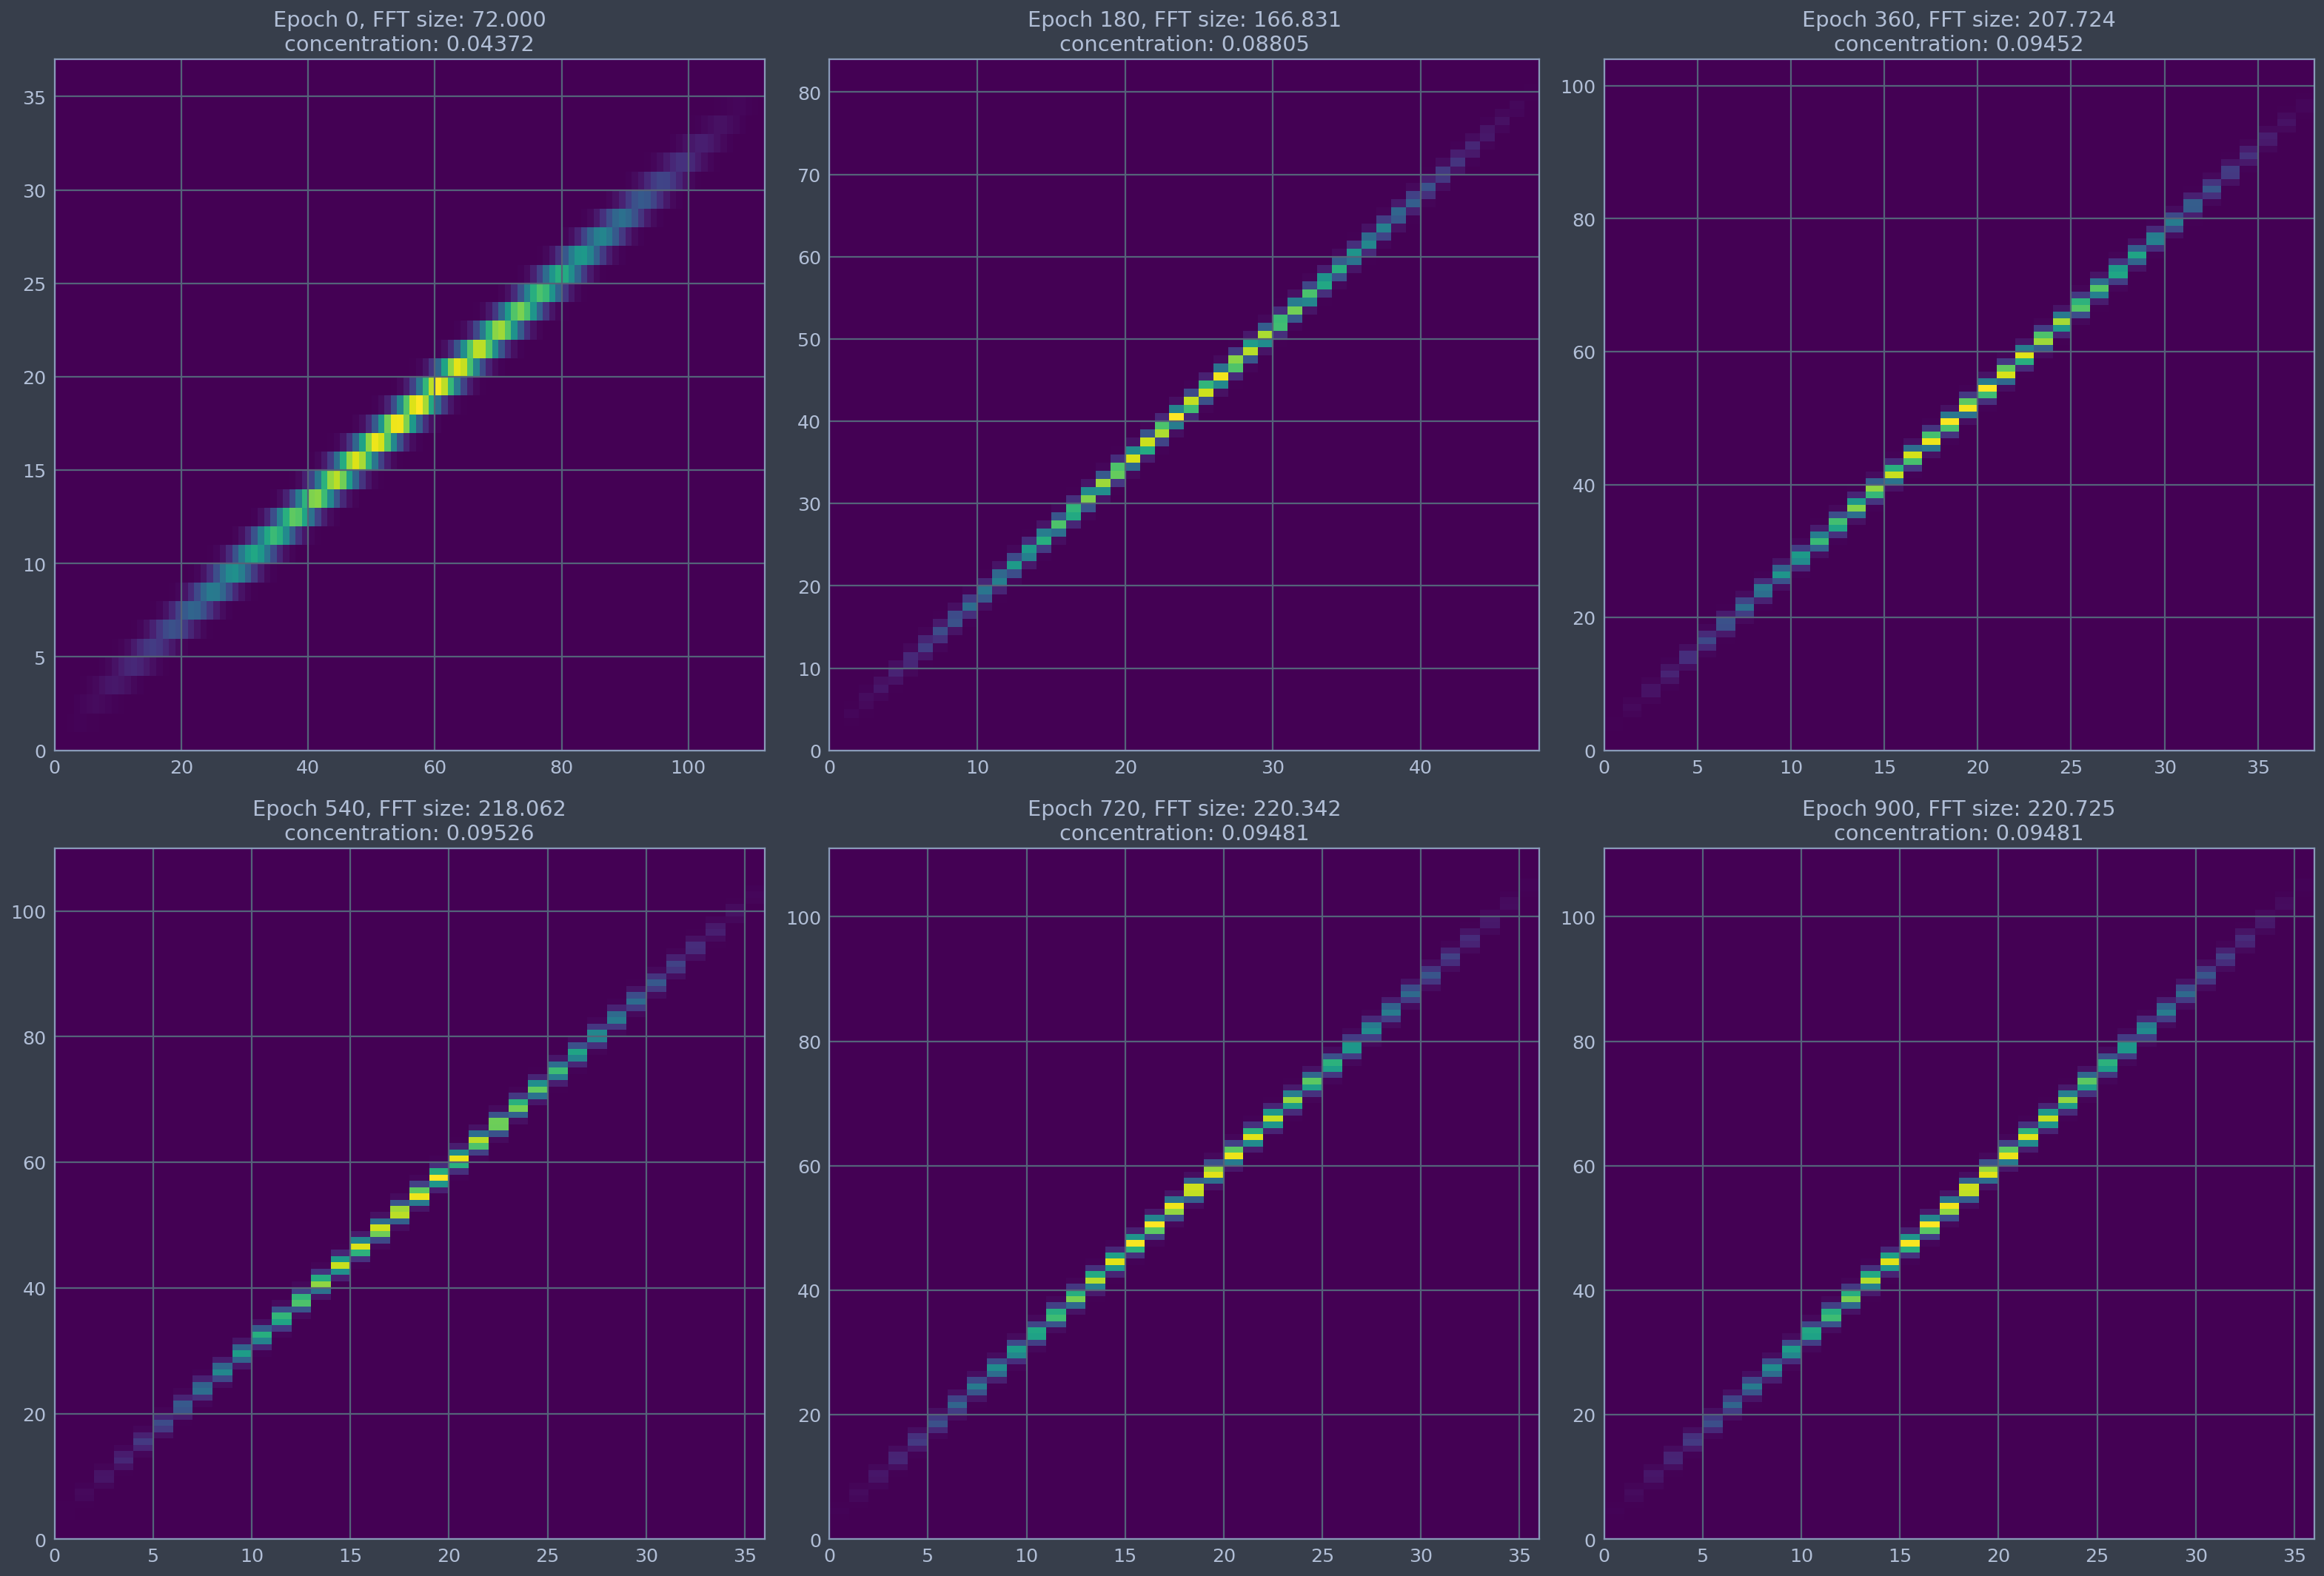

In [35]:
import tqdm
if hasattr(tqdm.tqdm, '_instances'):
    tqdm.tqdm._instances.clear()

sigma_grad_hist = []
window_times_signal_grads = []
try:
    torch.manual_seed(0)
    sigma_hist, kur_hist = optimize_entire_window_length(s)
except NumericalError as e:
    print(e)
    sigma_grad_hist = e.grad_hist
    window_times_signal_grads = e.window_times_signal_grads
    f_grad = e.f_grad
    raise e

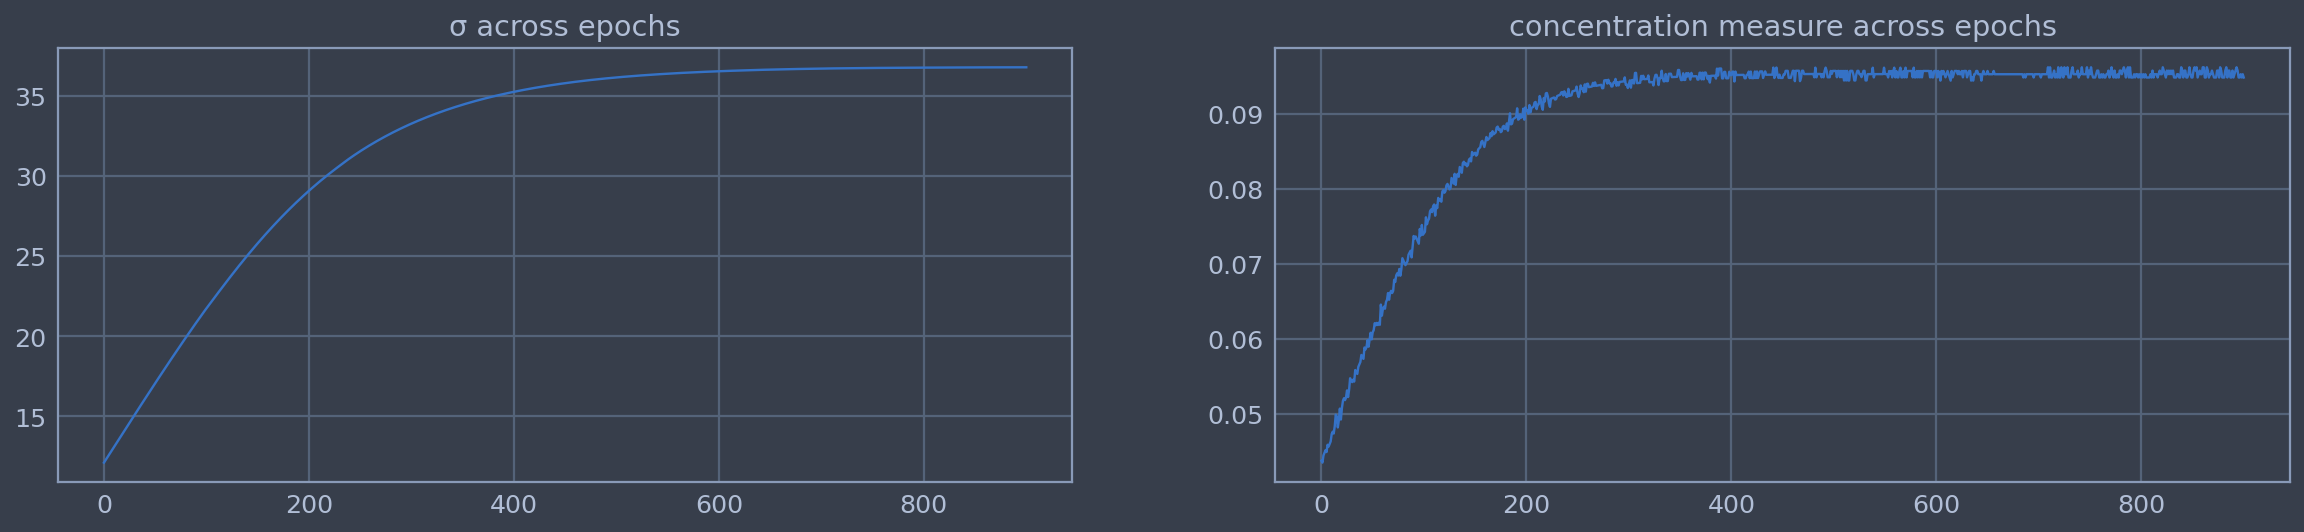

In [36]:
plt.figure(figsize=(20, 4))
_ = plt.gcf().add_subplot(1, 2, 1), plt.gca().plot(sigma_hist), plt.gca().set_title("σ across epochs")
_ = plt.gcf().add_subplot(1, 2, 2), plt.gca().plot(kur_hist), plt.gca().set_title("concentration measure across epochs")